# **Multi-inference implicit chain of reasoning demonstration**

Here I attempt to solve this challenge [here](https://yuntiandeng.com/cv/challenge.png) by referencing the research paper and source code linked below.

| ||
|----------|----------|
| Research Credit | [here](https://arxiv.org/pdf/2311.01460.pdf) |
| Code Inspiration Credit | [github](https://github.com/da03/implicit_chain_of_thought/tree/main) |

In [1]:
import sys
import os

#For safe imports
notebook_directory = os.getcwd()
parent_directory = os.path.dirname(notebook_directory)
sys.path.insert(False, parent_directory)


In [2]:
parent_directory = os.path.dirname(notebook_directory)

### **Dataset Generation**
Here we generate our test and train data. We generate our training data randomly such that it represents less than **1%** of possible observations. We also generate our tokenized data here as well.

---

The format of training and test datasets follow this format:

```
[input 1a] $$$ [input 1b]||[CoT 1a] $$$ [CoT 1b] #### [output 1a] $$$ [output 1b]
[input 2a] $$$ [input 2b]||[CoT 2a] $$$ [CoT 2b] #### [output 2a] $$$ [output 2b]
[input 3a] $$$ [input 3b]||[CoT 3a] $$$ [CoT 3b] #### [output 3a] $$$ [output 3b]
```

We can also test any particular case using the DatasetHandler. We create a custom prediction dataset as well.

In [3]:
from data.data import DatasetHandler
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('gpt2')

training_data_size = 77700
test_data_size = 7700

datahandler_train = DatasetHandler(tokenizer = tokenizer, parent_path = parent_directory, max_len = 1024, type = 'train')
datahandler_test = DatasetHandler(tokenizer = tokenizer, parent_path = parent_directory, max_len = 1024, type = 'test')

Now we generate datasets for each handler.

In [4]:
datahandler_train.generateDataset(size = training_data_size)
datahandler_test.generateDataset(size = test_data_size)

Generated raw train dataset saved at c:\Users\Luke\multi_implicit_cot\data\raw_train_dataset.txt of size 77700.
Creating tokenized features from dataset file at c:\Users\Luke\multi_implicit_cot\data\raw_train_dataset.txt
tgt_avg:  21.0
src_avg:  13.0
ratios:  0.6190476190476191
tgt_avg:  15.0
src_avg:  13.0
ratios:  0.8666666666666667
---------------------------
Example features:
Full entry:  2 4 * 5 3 $$$ 5 0 * 2 0 <|endoftext|> 0 1 2 + 0 6 2 1 $$$ 0 1 0 + 0 0 0 0 <|endoftext|> #### 0 7 4 1 $$$ 0 1 0 0 <|endoftext|>
No CoT:  2 4 * 5 3 $$$ 5 0 * 2 0 <|endoftext|> #### 0 7 4 1 $$$ 0 1 0 0 <|endoftext|>
Only CoT:  2 4 * 5 3 $$$ 5 0 * 2 0 <|endoftext|> 0 1 2 + 0 6 2 1 $$$ 0 1 0 + 0 0 0 0 <|endoftext|>
Product input:  2 4 * 5 3 $$$ 5 0 * 2 0 <|endoftext|> 
---------------------------
Generated raw test dataset saved at c:\Users\Luke\multi_implicit_cot\data\raw_test_dataset.txt of size 7700.
Creating tokenized features from dataset file at c:\Users\Luke\multi_implicit_cot\data\raw_test_data

Here we allow the creation of a custom prediction. The custom prediction is of the form **a*b** and **c*d**.

In [5]:
#Custom prediction 
a=10
b=5
c=9
d=98

custom_prediction = DatasetHandler(tokenizer = tokenizer, parent_path = parent_directory, max_len = 1024, type = 'custom')
custom_prediction.generateDataset(a=10, b=5, c=9, d=98)

Generated raw custom dataset saved at c:\Users\Luke\multi_implicit_cot\data\raw_custom_dataset.txt of size 1.
Creating tokenized features from dataset file at c:\Users\Luke\multi_implicit_cot\data\raw_custom_dataset.txt
tgt_avg:  21.0
src_avg:  13.0
ratios:  0.6190476190476191
tgt_avg:  15.0
src_avg:  13.0
ratios:  0.8666666666666667
---------------------------
Example features:
Full entry:  0 1 * 5 0 $$$ 9 0 * 8 9 <|endoftext|> 0 5 0 + 0 0 0 0 $$$ 2 7 0 + 0 1 8 0 <|endoftext|> #### 0 5 0 0 $$$ 2 8 8 0 <|endoftext|>
No CoT:  0 1 * 5 0 $$$ 9 0 * 8 9 <|endoftext|> #### 0 5 0 0 $$$ 2 8 8 0 <|endoftext|>
Only CoT:  0 1 * 5 0 $$$ 9 0 * 8 9 <|endoftext|> 0 5 0 + 0 0 0 0 $$$ 2 7 0 + 0 1 8 0 <|endoftext|>
Product input:  0 1 * 5 0 $$$ 9 0 * 8 9 <|endoftext|> 
---------------------------


### **Model Training**
Here we begin training our individual models.

---


In [6]:
from source.teacher import Teacher
from source.configurations import TeacherConfig

from source.thought_emulator import ThoughtEmulator
from source.configurations import ThoughtEmulatorConfig

from source.mindreading_emulator import MindReadingEmulator
from source.configurations import MindReadingEmulatorConfig


In [7]:
teacher_config = TeacherConfig()
teacher_model = Teacher(teacher_config)

t_emulator_config = ThoughtEmulatorConfig()
t_emulator_model = ThoughtEmulator(t_emulator_config, teacher_model)

mr_emulator_config = MindReadingEmulatorConfig()
mr_emulator_model = MindReadingEmulator(t_emulator_config, teacher_model)

##### **Teacher Model**
This model takes in inputs and generates a CoT and product as output.

  0%|          | 1/2429 [00:01<1:00:20,  1.49s/it]

Step: 0. PPL: 91.948341. Training Accuracy: 0.181985


 10%|█         | 243/2429 [01:15<10:53,  3.35it/s]

Step: 242. PPL: 1.723134. Training Accuracy: 0.795956


 20%|█▉        | 485/2429 [02:27<09:59,  3.24it/s]

Step: 484. PPL: 1.307921. Training Accuracy: 0.892463


 30%|██▉       | 727/2429 [03:41<08:38,  3.28it/s]

Step: 726. PPL: 1.185997. Training Accuracy: 0.938419


 40%|███▉      | 969/2429 [05:02<08:17,  2.93it/s]

Step: 968. PPL: 1.084974. Training Accuracy: 0.969669


 49%|████▊     | 1179/2429 [06:06<06:28,  3.22it/s]


Accuracy limit reached, stopping training at training accuracy: 0.993566.
Evaluating test dataset now...


  0%|          | 1/241 [00:00<01:56,  2.06it/s]

Input:  2 1 * 5 9 $$$ 0 6 * 3 3 
Target:  0 6 0 + 0 8 0 1 $$$ 0 8 1 + 0 0 8 1  #### 0 4 1 1 $$$ 0 8 9 1 
Predicted:  0 6 0 + 0 8 0 1 $$$ 0 8 1 + 0 0 8 1  #### 0 4 1 1 $$$ 0 8 9 1 



  1%|          | 2/241 [00:00<01:56,  2.04it/s]

Input:  8 2 * 5 3 $$$ 4 2 * 3 4 
Target:  0 4 1 + 0 4 8 0 $$$ 2 7 0 + 0 6 9 0  #### 0 8 9 0 $$$ 2 3 0 1 
Predicted:  0 4 1 + 0 4 8 0 $$$ 2 7 0 + 0 6 9 0  #### 0 8 9 0 $$$ 2 3 0 1 



  1%|          | 3/241 [00:01<01:56,  2.04it/s]

Input:  4 6 * 7 0 $$$ 3 8 * 6 5 
Target:  8 4 4 + 0 0 0 0 $$$ 8 9 4 + 0 5 1 4  #### 8 4 4 0 $$$ 8 4 6 4 
Predicted:  8 4 4 + 0 0 0 0 $$$ 8 9 4 + 0 5 1 4  #### 8 4 4 0 $$$ 8 4 6 4 



  2%|▏         | 4/241 [00:01<01:56,  2.04it/s]

Input:  6 1 * 0 9 $$$ 0 8 * 6 4 
Target:  0 0 0 + 0 4 4 1 $$$ 0 8 4 + 0 0 2 3  #### 0 4 4 1 $$$ 0 8 6 3 
Predicted:  0 0 0 + 0 4 4 1 $$$ 0 8 4 + 0 0 2 3  #### 0 4 4 1 $$$ 0 8 6 3 



100%|██████████| 241/241 [01:53<00:00,  2.13it/s]


Perplexitity: 1.018013; Test Accuracy: 0.834545; Training Accuracy: 0.994408.
Saving to c:\Users\Luke\multi_implicit_cot\models\teacher


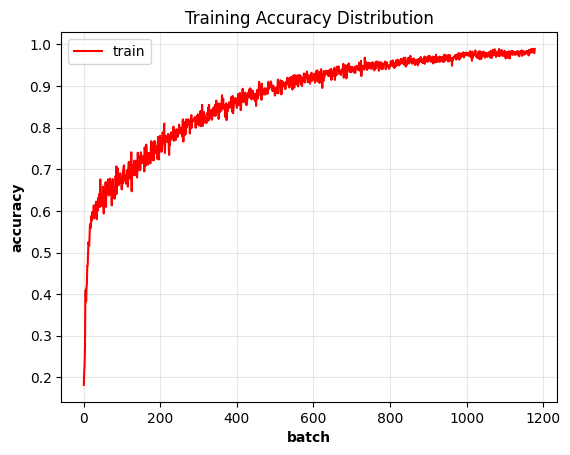

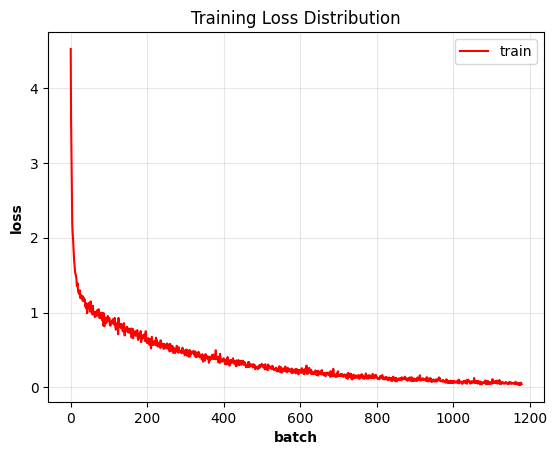

In [8]:
teacher_model.train(train_handler = datahandler_train, test_handler = datahandler_test, limit = 0.99)

##### **Thought Emulator Model**
This model takes the input and predicts the teacher states. We calculate a proxy for accuracy by taking the mean difference in layer states between the teacher model and itself.

  0%|          | 1/2429 [00:00<30:47,  1.31it/s]

Step: 0. Loss: 7143.733398. Quasi Training Accuracy: 0.167040.


 10%|█         | 243/2429 [01:22<12:32,  2.90it/s]

Step: 242. Loss: 333.748535. Quasi Training Accuracy: 0.829151.


 20%|█▉        | 485/2429 [02:45<11:11,  2.89it/s]

Step: 484. Loss: 255.859909. Quasi Training Accuracy: 0.853324.


 30%|██▉       | 727/2429 [04:06<09:26,  3.01it/s]

Step: 726. Loss: 215.005371. Quasi Training Accuracy: 0.866190.


 40%|███▉      | 969/2429 [05:30<08:56,  2.72it/s]

Step: 968. Loss: 178.495529. Quasi Training Accuracy: 0.881432.


 50%|████▉     | 1211/2429 [07:07<08:16,  2.45it/s]

Step: 1210. Loss: 159.853058. Quasi Training Accuracy: 0.888050.


 60%|█████▉    | 1453/2429 [08:46<06:37,  2.45it/s]

Step: 1452. Loss: 135.725098. Quasi Training Accuracy: 0.896811.


 70%|██████▉   | 1695/2429 [10:26<04:59,  2.45it/s]

Step: 1694. Loss: 129.002640. Quasi Training Accuracy: 0.900692.


 80%|███████▉  | 1937/2429 [12:05<03:01,  2.71it/s]

Step: 1936. Loss: 107.112823. Quasi Training Accuracy: 0.908731.


 90%|████████▉ | 2179/2429 [13:34<01:34,  2.65it/s]

Step: 2178. Loss: 89.093475. Quasi Training Accuracy: 0.915337.


100%|█████████▉| 2421/2429 [15:08<00:03,  2.61it/s]

Step: 2420. Loss: 76.854797. Quasi Training Accuracy: 0.920826.


100%|██████████| 2429/2429 [15:11<00:00,  2.66it/s]


Evaluating test dataset now...


100%|██████████| 241/241 [00:28<00:00,  8.31it/s]


Loss: 68.521061; Quasi Test Accuracy: 0.930888; Quasi Training Accuracy: 0.915584.
Saving to c:\Users\Luke\multi_implicit_cot\models\thought_emulator


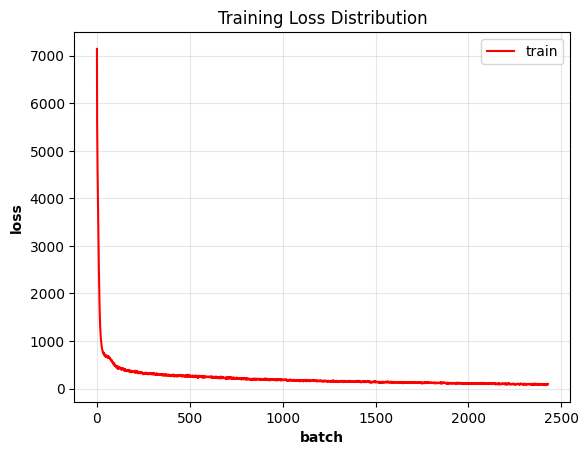

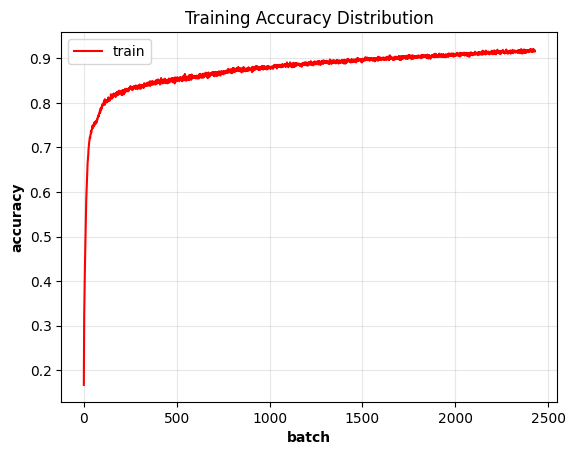

In [9]:
t_emulator_model.train(train_handler = datahandler_train, test_handler = datahandler_test, limit = 0.99)

##### **Mind Reading Emulator Model**
This model takes in the teacher states as input and predicts the output.

  0%|          | 1/2429 [00:00<21:31,  1.88it/s]

Step: 0. Loss: 5.832732. Training Accuracy: 0.022321.


 10%|█         | 243/2429 [01:36<15:16,  2.38it/s]

Step: 242. Loss: 0.792457. Training Accuracy: 0.696429.


 20%|█▉        | 485/2429 [03:20<14:29,  2.24it/s]

Step: 484. Loss: 0.687140. Training Accuracy: 0.725446.


 30%|██▉       | 727/2429 [05:04<11:35,  2.45it/s]

Step: 726. Loss: 0.574578. Training Accuracy: 0.787946.


 40%|███▉      | 969/2429 [06:47<10:04,  2.41it/s]

Step: 968. Loss: 0.449343. Training Accuracy: 0.830357.


 50%|████▉     | 1211/2429 [08:30<08:10,  2.48it/s]

Step: 1210. Loss: 0.409946. Training Accuracy: 0.843750.


 60%|█████▉    | 1453/2429 [10:13<07:02,  2.31it/s]

Step: 1452. Loss: 0.431973. Training Accuracy: 0.828125.


 70%|██████▉   | 1695/2429 [11:56<05:22,  2.28it/s]

Step: 1694. Loss: 0.362705. Training Accuracy: 0.861607.


 80%|███████▉  | 1937/2429 [13:37<03:37,  2.26it/s]

Step: 1936. Loss: 0.312069. Training Accuracy: 0.886161.


 90%|████████▉ | 2179/2429 [15:21<01:51,  2.24it/s]

Step: 2178. Loss: 0.277706. Training Accuracy: 0.886161.


100%|█████████▉| 2421/2429 [17:04<00:03,  2.32it/s]

Step: 2420. Loss: 0.267118. Training Accuracy: 0.897321.


100%|██████████| 2429/2429 [17:07<00:00,  2.36it/s]


Evaluating test dataset now...


  0%|          | 1/241 [00:05<22:16,  5.57s/it]

Input H. Layer 1, V. Layer 1, first 9 states:
[ 0.316  -0.0481  0.9685 -0.2544 -0.3191  0.2269 -1.2759 -0.2854 -0.3736]
Target:  #### 0 4 1 1 $$$ 0 8 9 1 
Predicted:  #### 0 8 1 1 $$$ 0 8 9 1 



  1%|          | 2/241 [00:11<21:54,  5.50s/it]

Input H. Layer 1, V. Layer 1, first 9 states:
[ 0.316  -0.0481  0.9685 -0.2544 -0.3191  0.2269 -1.2759 -0.2854 -0.3736]
Target:  #### 0 8 9 0 $$$ 2 3 0 1 
Predicted:  #### 0 4 9 0 $$$ 2 5 0 1 



  1%|          | 3/241 [00:16<22:11,  5.60s/it]

Input H. Layer 1, V. Layer 1, first 9 states:
[ 0.316  -0.0481  0.9685 -0.2544 -0.3191  0.2269 -1.2759 -0.2854 -0.3736]
Target:  #### 8 4 4 0 $$$ 8 4 6 4 
Predicted:  #### 8 4 4 0 $$$ 8 0 7 4 



  2%|▏         | 4/241 [00:22<21:49,  5.53s/it]

Input H. Layer 1, V. Layer 1, first 9 states:
[ 0.316  -0.0481  0.9685 -0.2544 -0.3191  0.2269 -1.2759 -0.2854 -0.3736]
Target:  #### 0 4 4 1 $$$ 0 8 6 3 
Predicted:  #### 0 4 4 1 $$$ 0 8 6 3 



100%|██████████| 241/241 [21:09<00:00,  5.27s/it]


Perplexitity: 1.273654; Test Accuracy: 0.133636; Training Accuracy: 0.898479.
Saving to c:\Users\Luke\multi_implicit_cot\models\mindreading_emulator


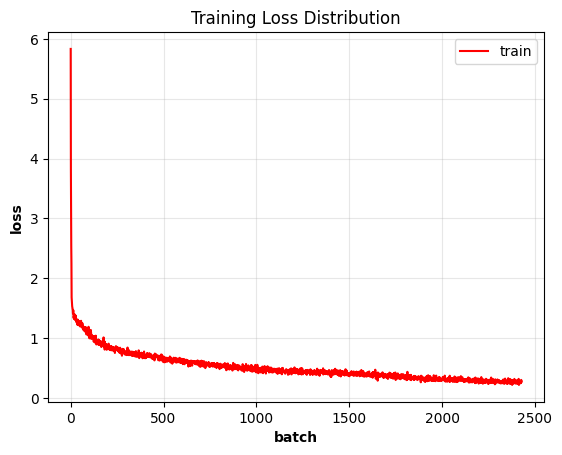

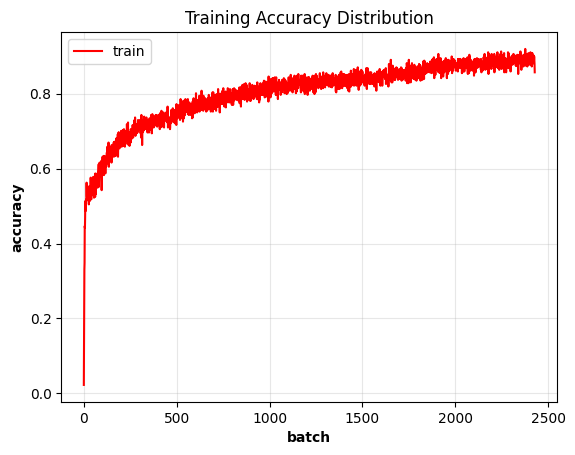

In [10]:
mr_emulator_model.train(train_handler = datahandler_train, test_handler = datahandler_test, limit = 0.99)

### **Prediction Demo**
Here we generate our custom test case to see results for each model. We include both the **thought emulator** and **mind reading emulator** to see how well it maps to states.

---

In [14]:
teacher_model.predict(custom_prediction)

100%|██████████| 1/1 [00:00<00:00,  1.69it/s]

Input:  0 1 * 5 0 $$$ 9 0 * 8 9 
Target:  0 5 0 + 0 0 0 0 $$$ 2 7 0 + 0 1 8 0  #### 0 5 0 0 $$$ 2 8 8 0 
Predicted:  0 5 0 + 0 0 0 0 $$$ 2 7 0 + 0 1 8 0  #### 0 5 0 0 $$$ 2 8 8 0 



In [15]:
t_emulator_model.predict(custom_prediction)

100%|██████████| 1/1 [00:00<00:00, 17.29it/s]

Input:  0 1 * 5 0 $$$ 9 0 * 8 9  
Target H. Layer 1, V. Layer 1, first 9 states:
[ 0.316  -0.0481  0.9685 -0.2544 -0.3191  0.2269 -1.2759 -0.2854 -0.3736]
Predicted H. Layer 1, V. Layer 1, first 9 states: 
[ 0.3239 -0.026   0.9755 -0.2419 -0.3062  0.2662 -1.2899 -0.2904 -0.4063]


In [16]:
mr_emulator_model.predict(custom_prediction)

100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

Input H. Layer 1, V. Layer 1, first 9 states:
[ 0.316  -0.0481  0.9685 -0.2544 -0.3191  0.2269 -1.2759 -0.2854 -0.3736]
Target:  #### 0 5 0 0 $$$ 2 8 8 0 
Predicted:  #### 0 5 0 0 $$$ 2 8 8 0 

